# Cantilever Bending Roll-up (corotational)

A Cantilever beam is subjected to a total end-moment about the Y axis $M_y=n 2 \pi E I / L$, where $n$ is the number of rotations ( 2 in this example).

See [ASDShellQ4 Element Example 1](https://opensees.github.io/OpenSeesDocumentation/user/manual/model/elements/ASDShellQ4.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from openseespy import opensees as ops

import opstool as opst


## Set up the model

In [2]:
# model and section
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
E = 1e4
h = 1.0
ops.section("ElasticMembranePlateSection", 1, E, 0.0, h)

# mesh
Lx = 20.0
Ly = 1.0
Nx = 20
Ny = 1
dLx = Lx / Nx
dLy = Ly / Ny
for j in range(Ny + 1):
    offset = j * (Nx + 1)
    jY = j * dLy
    for i in range(Nx + 1):
        iX = i * dLx
        ops.node(offset + i + 1, iX, jY, 0.0)
ele_id = 1
for j in range(Ny):
    for i in range(Nx):
        qids = (j * (Nx + 1) + i + 1, j * (Nx + 1) + i + 2, (j + 1) * (Nx + 1) + i + 2, (j + 1) * (Nx + 1) + i + 1)
        ops.element("ASDShellQ4", ele_id, *qids, 1, "-corotational")
        ele_id += 1

# fix
for j in range(Ny + 1):
    ops.fix(j * (Nx + 1) + 1, 1, 1, 1, 1, 1, 1)

# load
Nrolls = 2
M = Nrolls * 2.0 * np.pi * E * h**3 / 12 / Lx
dM = M / Ny / 2
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
for j in range(Ny):
    i = Nx - 1
    n1 = j * (Nx + 1) + i + 2
    n2 = (j + 1) * (Nx + 1) + i + 2
    ops.load(n1, 0, 0, 0, 0, -dM, 0)
    ops.load(n2, 0, 0, 0, 0, -dM, 0)

Using ASDShellQ4 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


In [3]:
fig = opst.vis.plotly.plot_model()
fig.show()
fig.write_html("model.html", full_html=False, include_plotlyjs="cdn")

## Analysis

In [4]:
# analysis
duration = 1.0
nsteps = 40
dt = duration / nsteps
dt_record = 0.2
ops.constraints("Transformation")
ops.numberer("RCM")
ops.system("UmfPack")
ops.test("NormDispIncr", 1.0e-5, 100, 0)
ops.algorithm("Newton")
ops.integrator("LoadControl", dt)
ops.analysis("Static")

In [5]:
ODB = opst.post.CreateODB(odb_tag="CantileverBendingRollup", project_gauss_to_nodes="copy")
for _ in range(nsteps):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = CantileverBendingRollup saved in 
.opstool.output/RespStepData-CantileverBendingRollup.nc!

## Post-processing

### Nodal response

``scale=False`` is used to avoid scaling the deformed shape in the plot.
This is necessary for this example because scaling would make the deformation appear incorrect.

In [6]:
opst.vis.plotly.set_plot_props(point_size=0)

fig = opst.vis.plotly.plot_nodal_responses_animation(
    odb_tag="CantileverBendingRollup",
    framerate=8,  # frames per second, 40 steps, 5 seconds total
    resp_type="disp",
    resp_dof=["UX", "UY", "UZ"],
    scale=False,
    unit_symbol="mm",
)
fig.show()
fig.write_html("nodal_resp.html", full_html=False, include_plotlyjs="cdn")

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-CantileverBendingRollup.nc ...

### Shell Nodal Stresses

In [7]:
fig = opst.vis.plotly.plot_unstruct_responses(
    odb_tag="CantileverBendingRollup",
    slides=True,
    ele_type="Shell",
    resp_type="StressesAtNodes",  # nodal stress response, "AtNodes"
    resp_dof="sigma22",  # sigma11, sigma22, sigma12, sigma13, sigma23
    shell_fiber_loc="bottom",  # shell_fiber_loc can be "top", "bottom", or "mid" for shell elements, also int
    # unit_symbol="kPa",
    # unit_factor=1,  # unit_factor is used to convert the response value, if MPa, set it to 1e-3
    show_defo=True,
    defo_scale=False,  # deformation scale factor not applied, set to False or 1.0
)
fig.show()
fig.write_html("shell_resp.html", full_html=False, include_plotlyjs="cdn")

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-CantileverBendingRollup.nc ...

### Xarray data processing

In [8]:
CNode = (Nx + 1) * (Ny + 1)

node_resp = opst.post.get_nodal_responses(odb_tag="CantileverBendingRollup")

print(node_resp)

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-CantileverBendingRollup.nc ...

<xarray.Dataset> Size: 255kB
Dimensions:             (time: 41, nodeTags: 42, DOFs: 6)
Coordinates:
  * time                (time) float32 164B 0.0 0.025 0.05 ... 0.95 0.975 1.0
  * nodeTags            (nodeTags) int32 168B 1 2 3 4 5 6 ... 37 38 39 40 41 42
  * DOFs                (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
Data variables:
    disp                (time, nodeTags, DOFs) float32 41kB 0.0 ... 3.595e-10
    vel                 (time, nodeTags, DOFs) float32 41kB 0.0 0.0 ... 0.0 0.0
    accel               (time, nodeTags, DOFs) float32 41kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float32 41kB 7.801e-14 ... 2.2...
    reactionIncInertia  (time, nodeTags, DOFs) float32 41kB 7.801e-14 ... 2.2...
    rayleighForces      (time, nodeTags, DOFs) float32 41kB 0.0 0.0 ... 0.0 0.0
    pressure            (time, nodeTags) float32 7kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction


In [9]:
disp = node_resp["disp"].sel(nodeTags=CNode)
uz = disp.sel(DOFs="UZ")
ux = disp.sel(DOFs="UX")
uy = disp.sel(DOFs="UY")
ry = -disp.sel(DOFs="RY")

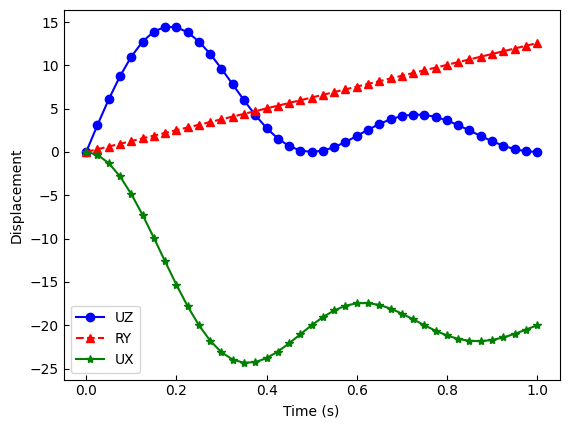

In [10]:
plt.plot(uz.time, uz.values, "-bo", label="UZ")
plt.plot(ry.time, ry.values, "--r^", label="RY")
plt.plot(ux.time, ux.values, "-g*", label="UX")
plt.xlabel("Time (s)")
plt.ylabel("Displacement")
plt.legend()
plt.show()